In [17]:
#!pip install torch
#packages 
#Load packages :pytorch, sklearn etc.,
import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
#from torchvision.transforms import Normalize
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import copy
import time


In [3]:
#reading in the .npz file to train the model 
def get_training_data(load=False, datafile ='test_sn.npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './DS440-CAPSTONE/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        training_t = []  
        training_f = []
        training_class = []
        training_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(1)
                    training_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(0)
                    training_info.append(info)
        np.savez(datafile,training_t = training_t, training_f = training_f,
                training_class = training_class, training_info = training_info)
        return training_t, training_f,training_class,training_info
    else:
        data = np.load(datafile, allow_pickle=True)
        training_t = data['training_t']         # needs to be padded and then shuffled
        training_f = data['training_f']         
        training_class = data['training_class']  
        training_info = data['training_info']   
        return training_t, training_f,training_class,training_info
training_t, training_f,training_class,training_info = get_training_data(load=True)

In [4]:
#padding the arrays to match the max size
longest_len = 3658
for i in np.arange(len(training_t)):
    mylen = len(training_t[i])
    if mylen>longest_len:
        longest_len = mylen
new_training_t = np.zeros((len(training_t),longest_len))
new_training_f = np.zeros((len(training_t),longest_len))
for i in np.arange(len(training_t)):
    nl = len(training_t[i])
    before_N=int(longest_len/2-(nl/2))
    new_training_t[i,before_N:nl+before_N] = training_t[i]   # Data to be used
    new_training_f[i,before_N:nl+before_N] = training_f[i]   # Data to be used

In [5]:
float_nt_f = new_training_f.astype(np.float64)

In [6]:
type(float_nt_f)

numpy.ndarray

In [7]:
float_nt_f

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
new_training_f.shape

(20398, 3658)

In [9]:
training_class.shape

(20398,)

In [10]:
# introducing balanced dataset 

#new set with 50/50 SNe
count_arr = np.bincount(training_class)
count1 = count_arr[1]
count0 = count_arr[0]

#get index of 0's, 1's-> np.where 
#np.random.choice?(replace= False ) returns a random sample of zeroes. 

zero=np.where(training_class==0)[0]  # the [0] just means the first "element" in this case array is selected. np.where makes a matrix of size nx2 for some reason 
one = np.where(training_class==1)[0] 
#get the indexes
train_c0 = np.random.choice(zero, size=3900, replace=False, p=None)
train_f0 = new_training_f[train_c0]
train_c00= training_class[train_c0]

train_f1 = new_training_f[one]
train_c11 = training_class[one]

train_c_all = np.append(train_c00,train_c11)
train_f_all = np.vstack((train_f0,train_f1))

In [11]:
one = np.where(training_class==1)[0] 
print(len(one))

3900


In [18]:
scaler = MinMaxScaler()

train_f_all = scaler.fit_transform(train_f_all.T).T

In [20]:
class CustomDataset(data.Dataset):
    def __init__(self, train_c_all, train_f_all, transform=None, target_transform=None):   #train_c_all,train_f_all -                                                                                    
        self.labels = train_c_all                                                       #from balanced set 
        self.data = train_f_all
        self.transform = transform
        self.target_transform = target_transform
        
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.data, self.labels.iloc[idx, 0])
        curve = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            curve = self.transform(curve)
        if self.target_transform:
            label = self.target_transform(label)
        return curve, label

In [21]:
train = CustomDataset(train_c_all, train_f_all, transform=None, target_transform=None)

In [22]:
VALID_RATIO = 0.9
TEST_RATIO = 0.66

n_train_examples = int(len(train) * TEST_RATIO)
n_test_examples = len(train) - n_train_examples
n_train_examples = int(n_train_examples * VALID_RATIO)
n_valid_examples = len(train) - n_test_examples - n_train_examples

In [23]:
train_data, test_data, valid_data = data.random_split(train, [n_train_examples, n_test_examples, n_valid_examples])

In [24]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [25]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 1400)
        self.hidden_fc1 = nn.Linear(1400, 530)
        self.hidden_fc2 = nn.Linear(530, 200)
        self.hidden_fc3 = nn.Linear(200, 80)
        self.output_fc = nn.Linear(80, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 1400]

        h_2 = F.relu(self.hidden_fc1(h_1))

        # h_2 = [batch size, 530]
        
        h_3 = F.relu(self.hidden_fc2(h_2))

        # h_3 = [batch size, 200]
        
        h_4 = F.relu(self.hidden_fc3(h_3))

        # h_4 = [batch size, 80]

        y_pred = self.output_fc(h_4)

        # y_pred = [batch size, output dim]

        return y_pred, h_4

define our model by creating an instance of it and setting the correct input and output dimensions.

In [26]:
INPUT_DIM = 3658
OUTPUT_DIM = 2

model = MLP(INPUT_DIM, OUTPUT_DIM)

calculate the number of trainable parameters

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 3658 neurons connected to 1400 neurons, so 3658*1400 weighted connections plus 1400 bias terms.

The second layer has 1400 neurons connected to 530 neurons, 1400*530 weighted connections plus 530 bias terms.

The third layer has 530 neurons connected to 200 neurons, 530*200 weighted connections plus 200 bias terms.

The fourth layer has 200 neurons connected to 80 neurons, 200*80 weighted connections plus 80 bias terms.

The fifth layer has 80 neurons connected to 2 neurons, 80*2 weighted connections plus 2 bias terms.

$$3658 \cdot 1400 + 1400 + 1400 \cdot 530 + 530 + 530 \cdot 200 + 200 + 200 \cdot 80 + 80 + 80 \cdot 2 + 2 = 5,987,572 $$

In [28]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,987,572 trainable parameters


In [29]:
optimizer = optim.Adam(model.parameters())  # lr = 0.1, momentum =0.9

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
model = model.to(device)
criterion = criterion.to(device)

In [34]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [35]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x.float())

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [36]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x.float())

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.524 | Train Acc: 73.54%
	 Val. Loss: 0.417 |  Val. Acc: 86.28%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.377 | Train Acc: 87.17%
	 Val. Loss: 0.376 |  Val. Acc: 87.85%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.354 | Train Acc: 86.90%
	 Val. Loss: 0.304 |  Val. Acc: 89.24%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.280 | Train Acc: 89.98%
	 Val. Loss: 0.271 |  Val. Acc: 90.97%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.244 | Train Acc: 91.09%
	 Val. Loss: 0.277 |  Val. Acc: 90.10%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.232 | Train Acc: 91.14%
	 Val. Loss: 0.270 |  Val. Acc: 90.80%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.252 | Train Acc: 90.73%
	 Val. Loss: 0.234 |  Val. Acc: 92.88%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.227 | Train Acc: 91.78%
	 Val. Loss: 0.267 |  Val. Acc: 90.10%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.240 | Train Acc: 91.15%
	 Val. Loss: 0.244 |  Val. Acc: 91.67%


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 0.236 | Train Acc: 91.06%
	 Val. Loss: 0.272 |  Val. Acc: 87.62%


In [39]:
##rename the .pt file

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

In [40]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.267 | Test Acc: 91.10%


In [ ]:
# find how to plot the test loss against training loss

Examining the model

In [41]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x.float())

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [42]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

tensor([1, 0, 0,  ..., 0, 1, 1])

In [43]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (10).

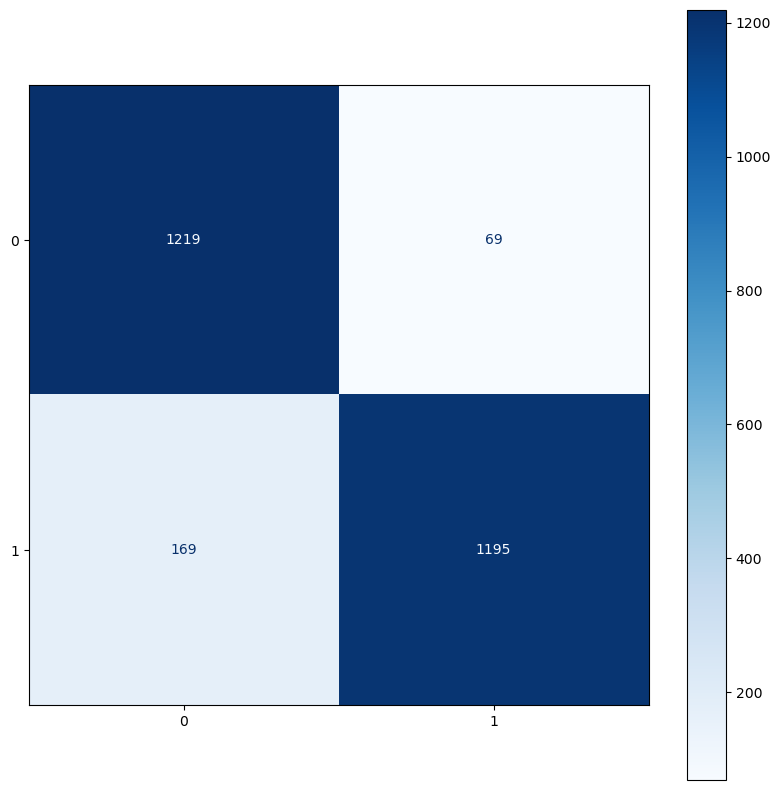

In [44]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
# conclusion kinda did worse than before?
# the data being already imbalanced 
# next to 

In [46]:
#reading in a small test set with real SNe to see how the model actually performs.
# Some actual testing on SNe = test_sn.npz
#read in the data 
def get_testing_data(load=False, datafile ='testdata_set(1).npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './pipelinefile_/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        test_t = []  
        test_f = []
        test_class = []
        test_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(1)
                    test_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(0)
                    test_info.append(info)
        np.savez(datafile,testg_t = test_t, test_f = test_f,
                test_class = test_class, test_info = test_info)
        return test_t, test_f,test_class,test_info
    else:
        data = np.load(datafile, allow_pickle=True)
        test_t = data['training_t']         # needs to be padded and then shuffled
        test_f = data['training_f']         
        test_class = data['training_class']  
        test_info = data['training_info']   
        return test_t, test_f,test_class,test_info
test_t, test_f,test_class,test_info = get_testing_data(load=True)


In [47]:
#adding padding to the curves
Xtest = np.array(test_f)
Ytest = np.array(test_class)

longest_len = 3658
for i in np.arange(len(Xtest)): 
    mylen = len(Xtest[i]) 
    if mylen>longest_len:
        longest_len = mylen
new_f = np.zeros((len(Xtest),longest_len)) 
for i in np.arange(len(Xtest)): 
    nl = len(Xtest[i]) 
    before_N=int(longest_len/2-(nl/2))
    new_f[i,before_N:nl+before_N] = Xtest[i]  
    

In [50]:
# normalizing the test set 
new_f = scaler.fit_transform(new_f.T).T

3658

In [51]:
# 
def get_test_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for x in iterator: #This may not work, I don't know what iterator expects
            x = torch.from_numpy(x)
            
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, probs

In [52]:
torch.set_default_tensor_type(torch.FloatTensor)

In [53]:
x2 = torch.from_numpy(new_f)

In [54]:
y_pred, _ = model(x2.float())



In [55]:
y_prob = F.softmax(y_pred, dim=-1)

In [56]:
y_prob = y_prob.detach().numpy()


In [57]:
y_pred = y_pred.detach().numpy()

(array([[ 0.,  0.,  0.,  0.,  2., 16., 22., 33., 61., 33.],
        [33., 58., 29., 22., 20.,  3.,  0.,  2.,  0.,  0.]]),
 array([-2.3548076 , -1.9048398 , -1.4548719 , -1.0049039 , -0.55493605,
        -0.10496819,  0.3449997 ,  0.7949676 ,  1.2449355 ,  1.6949034 ,
         2.1448712 ], dtype=float32),
 <a list of 2 BarContainer objects>)

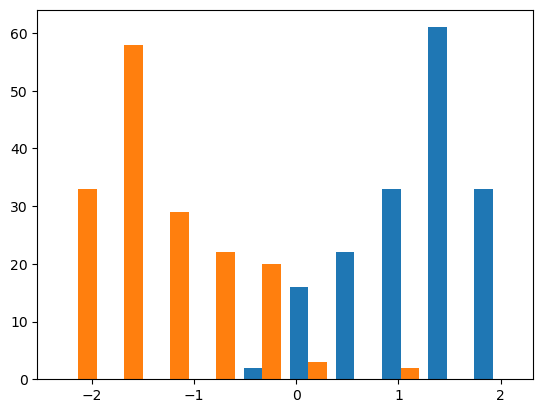

In [58]:
plt.hist(y_pred)

(array([112.,  16.,  14.,   2.,  10.,   9.,   2.,   0.,   0.,   2.]),
 array([0.01099044, 0.09021447, 0.1694385 , 0.24866253, 0.32788655,
        0.4071106 , 0.48633462, 0.5655587 , 0.6447827 , 0.7240067 ,
        0.80323076], dtype=float32),
 <BarContainer object of 10 artists>)

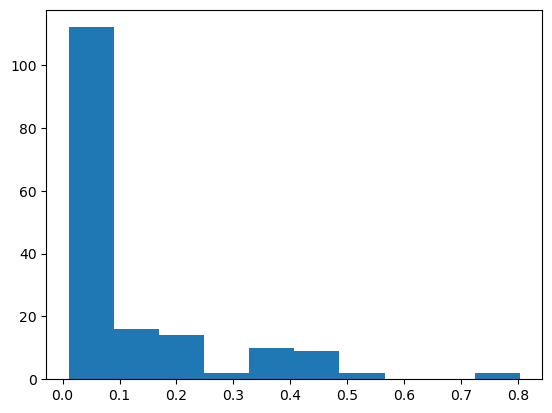

In [59]:
plt.hist(y_prob[:,1])

In [70]:
np.where(y_prob[:,1]>0.4)

(array([  9,  10,  11,  12,  16,  38,  88,  89, 113, 114, 115, 116, 117,
        118], dtype=int64),)

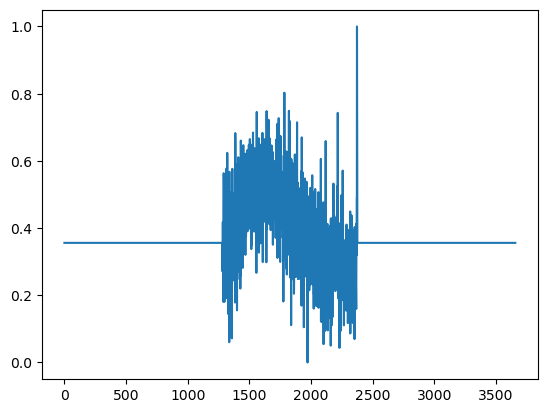

In [71]:
plt.plot(new_f[9])